In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Query the Measurement table to see whats inside
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# Query the Measurement table to see what the column keys are
engine.execute('SELECT * FROM measurement LIMIT 5').keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [12]:
# Query the Station table to see whats inside
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [13]:
# Query the Station table to see what the column keys are
engine.execute('SELECT * FROM station LIMIT 5').keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Create a selection to get the station, date, percp, and tobs
sel = [(Measurement.station).label("Station"), 
       (Measurement.date).label("Date"), 
       (Measurement.prcp).label("Percipitation"), 
       (Measurement.tobs).label("TOBS")]

# Calculate the Max date by querying the sql lite database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Turn the result into a date/time item
max_date_dt = pd.to_datetime(max_date)

# Calculate a year back from the max date
date_year_back = max_date_dt - dt.timedelta(days=365)

# Turn the year back into a string
year_back_str = date_year_back.strftime("%Y-%m-%d")[0]

# Query the Measurement database for all the data
year_data = session.query(*sel).\
                filter(Measurement.date >= year_back_str).\
                order_by(Measurement.date).\
                statement

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column (drop NAN as well)
df_all = pd.read_sql_query(year_data, session.bind.engine)
df_all = df_all.dropna()
df_all.head()

,Station,Date,Percipitation,TOBS
0,USC00519397,2016-08-23,0.00,81.0
1,USC00513117,2016-08-23,0.15,76.0
2,USC00514830,2016-08-23,0.05,80.0
4,USC00519523,2016-08-23,0.02,80.0
5,USC00519281,2016-08-23,1.79,77.0


In [16]:
# Cut out only the Date, and Percipitation columns to graph
df_graph = df_all[["Date", "Percipitation"]]
df_graph = df_graph.set_index("Date")
df_graph.head()

,Percipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


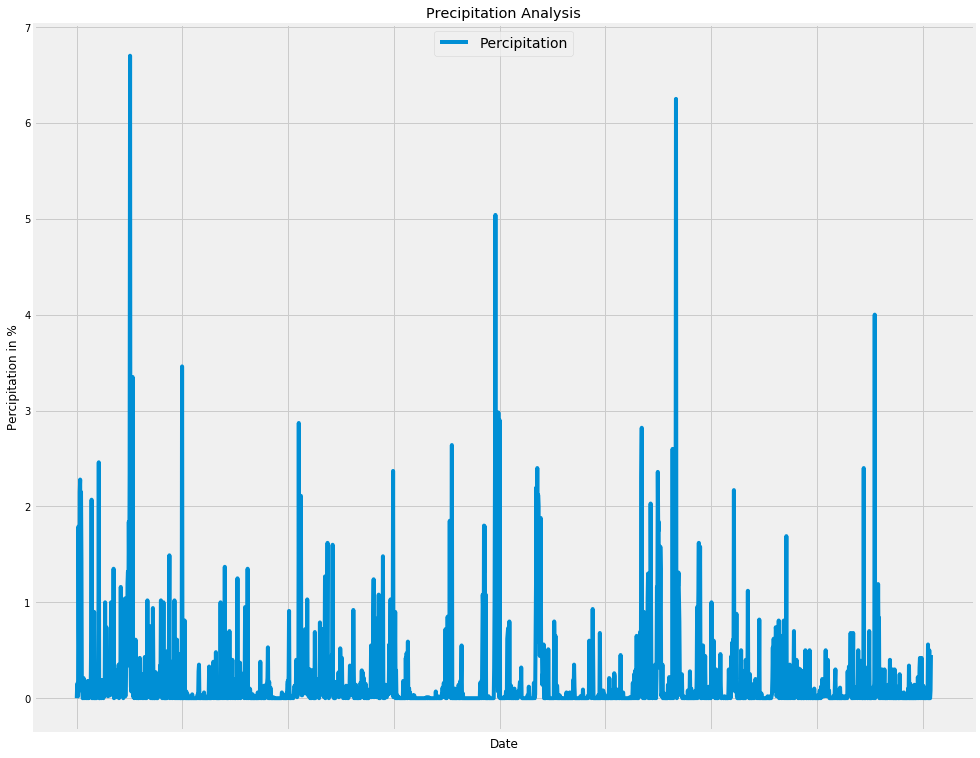

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df_graph.plot(figsize=(15,13), title="Precipitation Analysis")
plt.style.use('fivethirtyeight')
plt.legend(loc='upper center')
plt.ylabel('Percipitation in %')
plt.rcParams.update({'font.size': 15})
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_graph.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(distinct(Measurement.station)))
station_count.all()

[(9)]

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# Create selection for data needed
active_sel = [func.max(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.avg(Measurement.tobs)]

# Get the most active station by the counts (per above query)
active_highest_station = session.query(Measurement.station).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).first()

# Turn that active station into a string
active_highest_station_str = active_highest_station[0]

# Query the database for the information requested
active_station = session.query(*active_sel).\
                filter(Measurement.station == active_highest_station_str).\
                all()

active_station

[(85.0, 54.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.

# Create a selection to get the station, date, percp, and tobs
highest_sel = [(Measurement.station).label("Station"), 
       (Measurement.date).label("Date"), 
       (Measurement.prcp).label("Percipitation"), 
       (Measurement.tobs).label("TOBS")]

# Run query against database using query above and with required filters
highest_station = session.query(*highest_sel).\
                filter(Measurement.date >= year_back_str).\
                filter(Measurement.station == active_highest_station_str).\
                order_by(Measurement.date).\
                statement

In [23]:
# Create a Database of the data pulled (drop NAN as well)
df_highest_station_all = pd.read_sql_query(highest_station, session.bind.engine)
df_highest_station_all = df_highest_station_all.dropna()
df_highest_station_all.head()

,Station,Date,Percipitation,TOBS
0,USC00519281,2016-08-23,1.79,77.0
1,USC00519281,2016-08-24,2.15,77.0
2,USC00519281,2016-08-25,0.06,80.0
3,USC00519281,2016-08-26,0.01,80.0
4,USC00519281,2016-08-27,0.12,75.0


In [24]:
# Pull only data needed to graph
df_highest_station_graph = df_highest_station_all[["Date", "TOBS"]]
df_highest_station_graph = df_highest_station_graph.set_index("Date")
df_highest_station_graph.head()

,TOBS
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


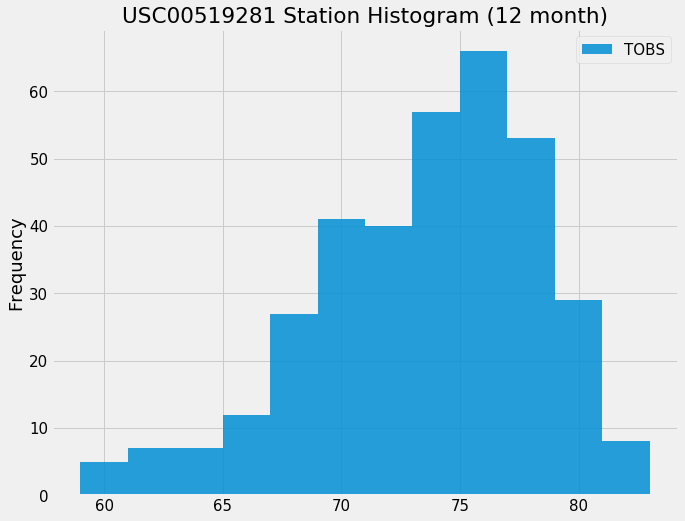

In [25]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
bins_month  = 12

df_highest_station_graph.plot.hist(bins=bins_month, title='USC00519281 Station Histogram (12 month)', figsize=(10, 8), alpha=0.85)
plt.style.use('fivethirtyeight')
plt.show()

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_dates = calc_temps('2017-07-25', '2017-08-10')
my_trip_dates

[(71.0, 79.09411764705882, 84.0)]

In [28]:
# Turn query results from calc_temnp above to dataframe
df_my_trip = pd.DataFrame(my_trip_dates, columns=['tmin', 'tavg', 'tmax'])
df_my_trip

,tmin,tavg,tmax
0,71.0,79.094118,84.0


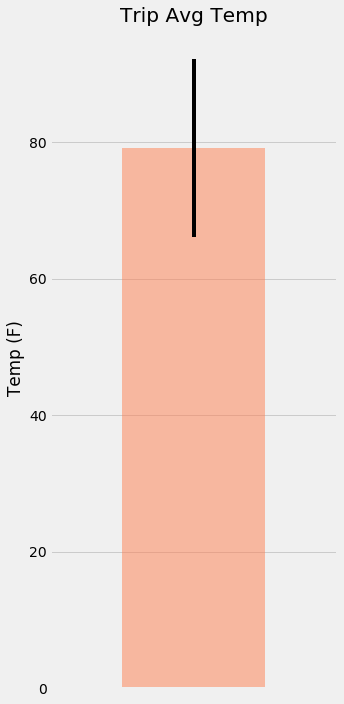

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

change = df_my_trip['tmax'] - df_my_trip['tmin']

ax = df_my_trip.plot.bar(title='Trip Avg Temp', y='tavg', yerr=change, color='coral', alpha=0.5, figsize = (5, 10))
plt.ylabel('Temp (F)')
plt.xticks([]) # disable xticks
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates
# using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the
# station, name, latitude, longitude, and elevation
sel_trip = [(Station.station).label("Station"), 
       (Station.name).label("Name"), 
       (Station.latitude).label("Latitude"), 
       (Station.longitude).label("Longitude"),
       (Station.elevation).label("Elevation"),
       (func.sum(Measurement.prcp).label("Total Rainfall"))]


my_trip = session.query(*sel_trip).\
                join(Measurement, Station.station == Measurement.station).\
                filter(Measurement.date >= "2017-07-25").\
                filter(Measurement.date <= "2017-08-10").\
                group_by(Station.station).\
                order_by(func.sum(Measurement.prcp).desc()).\
                all()

my_trip

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.52),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.62),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.6199999999999999),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.28),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.05),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.01)]

## Optional Challenge Assignment

In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("12-01")

[(65.0, 71.91666666666667, 78.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

def daterange(date1, date2):
    for n in range(int((date2 - date1).days)+1):
        yield date1 + dt.timedelta(n)


# Set the start and end date of the trip
start_trip = dt.date(2017, 7, 25)
end_trip = dt.date(2017, 8, 10)

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
d_range = []

for date in daterange(start_trip, end_trip):
    d_range.append(date.strftime("%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_range = []

for x in d_range:
    trip_range.append(daily_normals(x))

trip_range

[[(67.0, 76.89090909090909, 84.0)],
 [(71.0, 76.4423076923077, 86.0)],
 [(68.0, 76.58181818181818, 83.0)],
 [(69.0, 76.46428571428571, 82.0)],
 [(69.0, 76.47058823529412, 83.0)],
 [(69.0, 77.35185185185185, 84.0)],
 [(72.0, 77.03571428571429, 83.0)],
 [(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)],
 [(68.0, 76.5576923076923, 83.0)],
 [(69.0, 75.98039215686275, 81.0)],
 [(65.0, 76.42, 83.0)]]

In [33]:
# create list of dates to add to Pandas Dataframe

start_trip = dt.date(2017, 7, 25)
end_trip = dt.date(2017, 8, 10)

d_range_date = []

for date in daterange(start_trip, end_trip):
    d_range_date.append(date.strftime("%Y-%m-%d"))

d_range_date

['2017-07-25',
 '2017-07-26',
 '2017-07-27',
 '2017-07-28',
 '2017-07-29',
 '2017-07-30',
 '2017-07-31',
 '2017-08-01',
 '2017-08-02',
 '2017-08-03',
 '2017-08-04',
 '2017-08-05',
 '2017-08-06',
 '2017-08-07',
 '2017-08-08',
 '2017-08-09',
 '2017-08-10']

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

df_my_trip_range = pd.DataFrame(trip_range, columns=['export'])
df_my_trip_range = df_my_trip_range.export.apply(pd.Series)
df_my_trip_range.columns = ["tmin", "tavg", "tmax"]
df_my_trip_range["Date"] = pd.Series(d_range_date, index=df_my_trip_range.index)
df_my_trip_range = df_my_trip_range.set_index("Date")
df_my_trip_range.head()

,tmin,tavg,tmax
Date,,,
2017-07-25,67.0,76.890909,84.0
2017-07-26,71.0,76.442308,86.0
2017-07-27,68.0,76.581818,83.0
2017-07-28,69.0,76.464286,82.0
2017-07-29,69.0,76.470588,83.0


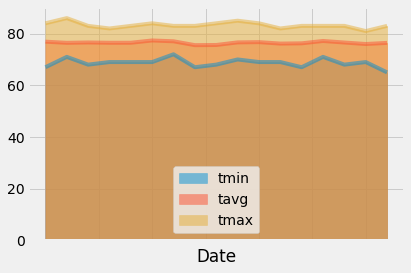

In [35]:
df_my_trip_range.plot.area(stacked = False)
plt.legend(loc = "lower center")
plt.show()